<img src='../img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>

For smooth experience some actions are needed:  
* Download the **MLST-ASv2** climatology in `NetCDF4` format from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MLST-ASv2/CLIM-NETCDF/). 
* Download **MLST-ASv2** data in `NetCDF4` format for the period 1 July 2023 to 31 August 2023 [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MLST-ASv2) in `NetCDF4`. 
</div>


# Plotting the Maximum Daily Temperature Anomaly

#### About

The aim of this notebook is to produce animated anomalies of daily maximum temperatures at specific geographical region. Additionally, it is meant to show general framework for calculating anomalies with LSA SAF data.

Work is based on the LSA SAF Land Surface Temperature - All Sky version 2 (MLST-ASv2) product which is currently in the demonstration phase, i.e. all the data may be subject to a change.

Daily maximum temperature is determined from multiple daily temperatures.
Similarly maximal temperatures could be obtained by using the [LSA SAF MLST](https://lsa-saf.eumetsat.int/en/data/products/land-surface-temperature-and-emissivity/) product.
For the period 2004-2022 the climatology is already pre-calculated and publicly accessible.

The focus will be on the heat waves in July and August of 2023 in the Mediterranean region.  Temperatures for July 2023 were much higher than their 1991-2020 averages over Southern Europe. Heatwaves were experienced from Spain in the west to the Balkans in the east. In Portugal, France and Italy heatwaves also extended in August.
Several temperature records were recorded at the time as described in [reference](https://climate.copernicus.eu/surface-air-temperature-august-2023). 



#### Basic Facts on the LSA SAF MLST-ASv2 

 > **Spatial resolution**: 3km at nadir 
 >
 > **Spatial coverage**: MSG disk 
 >
 > **Time steps**: 30 min  
 >
 > **Data availability**: from 2004

#### How to access the data

For this example, MLST-ASv2 measurements from 1 July 2023, to 31 August 2023 and [MLST-ASv2 Climatology](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MLST-ASv2/CLIM-NETCDF/) are used. All measurements are available as NetCDF4 file. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration. Data can be downloaded in various ways [tutorial](https://lsa-saf.eumetsat.int/en/user-support/tutorials/), for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program. [wget example](01_MLST_plot_NetCDF4.ipynb#wget)

#### Module Outline:
* [1 - Create a Geographical Subset and Find Maximum Daily Temperature](#subset)
* [2 - Calculate Anomaly for Subset Region](#anomaly)
* [3 - Create an Animation ](#animate)

#### Load Required Libraries

In [1]:
import matplotlib.pyplot as plt                     # a library that provides plotting capability
from matplotlib.animation import FuncAnimation      # a library that provides plotting capability
from matplotlib.ticker import FuncFormatter         # a library that provides plotting capability

import datetime as dt                               # a library that allows us to work with dates and times
import xarray as xr                                 # a library that helps us work efficiently with multidimensional arrays
import numpy as np                                  # a library that lets us work with arrays; we import this with a new name "np"
import pandas as pd                                 # a library for time series analysis

import cartopy.crs as ccrs                          # a library that supports mapping and projection 
import cartopy.feature as cf                        # a cartopy extension that support adding features, e.g. coastlines
import cartopy                                      # a library that supports mapping and projection
from IPython.display import HTML                    # a module to handle animations with Jupyter notebooks
from matplotlib import rcParams                     # is a dictionary-like object that stores default settings for matplotlib plots, allowing users to customize various properties. 

### <a id='subset'></a>1. Create a Geographical Subset and Find Maximum Daily Temperature

First, a list of dates of interest is generated. Since we work with multiple `NetCDF4` files, which could be memory consuming, we will load only a subset of the `NetCDF4` into a memory. Our area of interest, the Mediterranean, is specified at the beginning of the notebook.

In [2]:
# We can set start and end date using the following 2 variables:
start_date=dt.datetime(2022, 6, 30)
end_date=dt.datetime(2022, 7, 1)

# A list of days of interest is generated.
date_range = pd.date_range(start_date, end_date - dt.timedelta(days=1), freq="d")

# We only chose area, that we want to load to speed up the process
lat_slice = slice(55.0, 34.0)
lon_slice = slice(-10, 20)

# We can check the list of dates of interest
print(date_range)

DatetimeIndex(['2022-06-30'], dtype='datetime64[ns]', freq='D')


In [3]:
print (date_range[0])
print (date_range[0]+ dt.timedelta(minutes=1410))

2022-06-30 00:00:00
2022-06-30 23:30:00


We want to find out the maximum daily temperature. This is the highest measured temperature in the course of the day, therefore, we need to compare all the daily measurements.

First, we specify a list of times for which we have measurements. We need to construct a list of dates (`pd.datetime()` objects) and a list of hours in a day. This is achieved by constructing a list of 48 `pd.datetime()` objects (every 30 minutes) within the first date in the list of dates. We are then accessing year, month and day attributes inside the list of date_time objects from the list of times within a day.

The first measurement of the day is the first candidate for daily maximum temperature. Then we loop over all other measurements and check if they are greater than the previous maximum. In order to do so, the `xarray` dataset needs to be converted into a `numpy array` using `.values`.

<xarray.Dataset> Size: 2MB
Dimensions:        (lat: 421, lon: 601)
Coordinates:
  * lat            (lat) float32 2kB 55.0 54.95 54.9 54.85 ... 34.1 34.05 34.0
  * lon            (lon) float32 2kB -10.0 -9.95 -9.9 -9.85 ... 19.9 19.95 20.0
Data variables:
    Daily_maximum  (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan


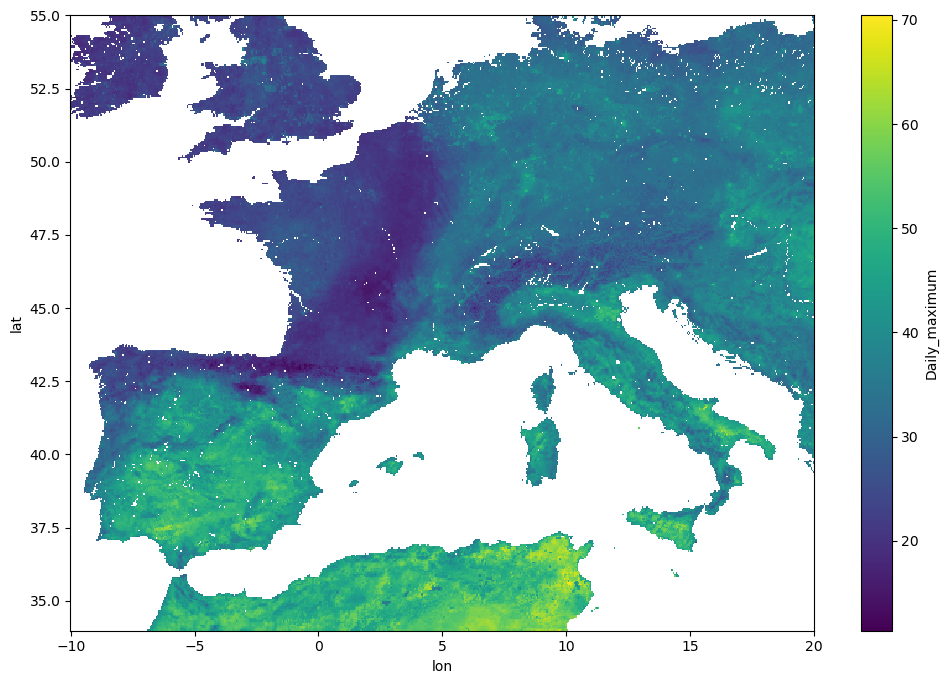

In [4]:
# Create a list of hours for which we have MLST-ASv2 data
day_range = pd.date_range(
    date_range[0],
    date_range[0] + dt.timedelta(minutes=1410),
    freq=dt.timedelta(minutes=30),
)

# Open the first datauy
first_ds = xr.open_dataset(
    "data/NETCDF4_LSASAF_MSG_MLST-ASv2_MSG-Disk_"
    + str("{:02d}".format(date_range[0].year))
    + str("{:02d}".format(date_range[0].month))
    + str("{:02d}".format(date_range[0].day))
    + str("{:02d}".format(day_range[0].hour))
    + str("{:02d}".format(day_range[0].minute))
    + ".nc"
)

# Load only a slice of the data (area of interest) into a memory
# Only MLST-AS values are loaded, without error, Q-flag etc.

first_ds = first_ds.sel(
    lat=lat_slice,
    lon=lon_slice,
    time=dt.datetime.combine(date_range[0].date(), day_range[0].time()),
)["MLST-AS"].load()

# Values from the dataset are saved into numpy array
# The first entry is the first candidate for maximum
max_np = first_ds.values

# Numpy array doesn't have its own coordinates,
# coordinates are  therefore saved separately

lat_coords = first_ds["lat"].values
lon_coords = first_ds["lon"].values

# We close the dataset to free the memory
first_ds.close()

# Loop over all the measurements in a day, the first hour is already checked
for i, time in enumerate(day_range[:-1], 0):

    # Define dataset
    next_ds = xr.open_dataset(
        "data/NETCDF4_LSASAF_MSG_MLST-ASv2_MSG-Disk_"
        + str("{:02d}".format(date_range[0].year))
        + str("{:02d}".format(date_range[0].month))
        + str("{:02d}".format(date_range[0].day))
        + str("{:02d}".format(day_range[i + 1].hour))
        + str("{:02d}".format(day_range[i + 1].minute))
        + ".nc"
    )

    # Load the data from the area on interest into a memory

    next_np = (
        next_ds.sel(
            lat=lat_slice,
            lon=lon_slice,
            time=dt.datetime.combine(date_range[0].date(), day_range[i + 1].time()),
        )["MLST-AS"]
        .load()
        .values
    )

    # Compare current values with current maximum and update maximum
    max_np = np.fmax(max_np, next_np)

    # Close dataset to free the memory
    next_ds.close()


# Dataset is created back from numpy array
# Coordinates saved before were used
max_xr_ds = xr.Dataset(
    data_vars={"Daily_maximum": (["lat", "lon"], max_np)},
    coords={"lat": lat_coords, "lon": lon_coords},
)

# Maximum daily temperature dataset is investigated
print(max_xr_ds)
max_xr_ds.Daily_maximum.plot(figsize=(12,8))

### <a id='anomaly'></a>2. Calculate the Anomaly Over a `NetCDF4` subset

We calculated the daily maximum. If we repeat this procedure over multiple days, we are able to observe the trends in daily maximum temperature.

To really detect deviations from expected temperature (i.e., climatology), the reference daily maximum temperature needs to be calculated. The daily maximum temperature climatology is already available as a part of the MLST-ASv2 product. The total size of the climatology (calculated from the multi-year data) is about 1.8 GB, therefore it is wise to load only the subset data into the memory.

To calculate anomaly, we compare the measured daily maximum temperature with the 2004-2022 climatology. The entries in the climatology `NetCDF4` file have assigned dates of creation in 2022, therefore we can call them with the list of dates, defined before and use of the `.replace(2022)` command.

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 421, lon: 601)
Coordinates:
    time     datetime64[ns] 8B 2022-06-30
  * lat      (lat) float32 2kB 55.0 54.95 54.9 54.85 ... 34.15 34.1 34.05 34.0
  * lon      (lon) float32 2kB -10.0 -9.95 -9.9 -9.85 ... 19.85 19.9 19.95 20.0
Data variables:
    MLST-AS  (lat, lon) float32 1MB ...
Attributes:
    date_created:         2023-09-26T14:52:03Z
    time_coverage_start:  2004-01-21T00:00:00Z
    time_coverage_end:    2022-12-31T00:00:00Z
    institution:          IPMA
    archive_facility:     IPMA
    license:              Data is freely available for users registered at th...
    contact:              helpdesk.landsaf@ipma.pt
    comment:              Daily climatology computed with a 11 days window
    history:              Wed Sep 27 13:31:36 2023: ncap2 -s time=time.conver...
    NCO:                  netCDF Operators version 4.9.9 (Homepage = http://n...


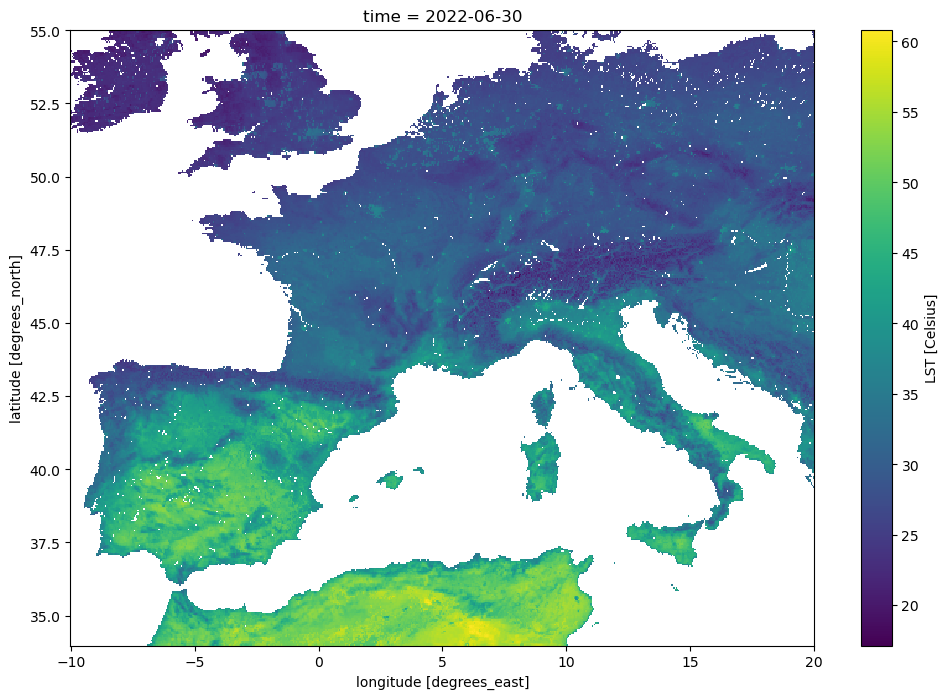

In [5]:
# Open the climatology netCDF4 file without loading
climatology_ds = xr.open_dataset(
    "auxfiles/NETCDF4_LSASAF_MSG_MLST-ASv2_MSG-Disk_DAILY-MAX_CLIM_2004-2022.nc"
)

# Load data only for the time of interest
# Climatology has a year of production 2022. .replace(2022) is needed
climatology_ds = climatology_ds.sel(
    time=date_range[0].replace(2022), lat=lat_slice, lon=lon_slice
)

# Climatology daily maximum temperature can be investigated
print(climatology_ds)
climatology_ds["MLST-AS"].plot(figsize=(12,8))

As mentioned before, the `xarray` dataset was loaded into a `numpy` array and we made all operations with `numpy`.

The `xarray` library allows for some operations to be made on the xarray datasets, e.g., addition, subtraction as well as a wide list of functions that can be applied using `xarray.apply_ufunc`, but we found this approach unstable when dealing with files with different metadata such as the case here.

In the next cell, we calculate the maximum daily temperature anomaly as the difference between the daily maximum and the climatology. The result is then packed into a `xarray` dataset by converting it from a 2D to a 3D array so that the resulting dataset has the same shape as the majority of LSA SAF products saved as NetCDF4 files.

<xarray.Dataset> Size: 2MB
Dimensions:                (time: 1, lat: 421, lon: 601)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2022-06-30
  * lat                    (lat) float32 2kB 55.0 54.95 54.9 ... 34.1 34.05 34.0
  * lon                    (lon) float32 2kB -10.0 -9.95 -9.9 ... 19.95 20.0
Data variables:
    Daily_maximum_anomaly  (time, lat, lon) float64 2MB nan nan nan ... nan nan


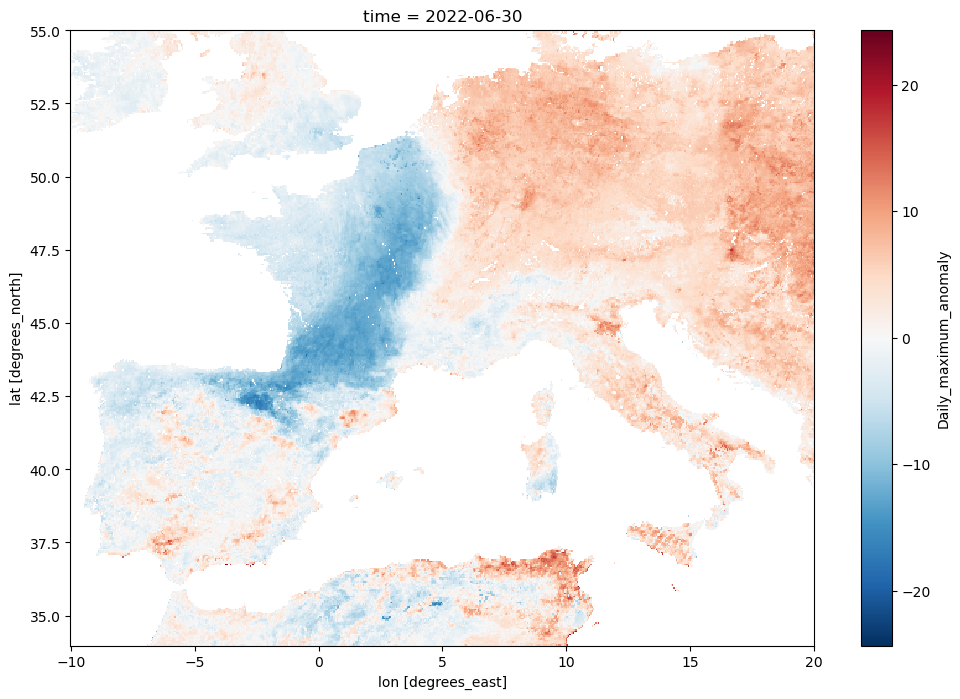

In [6]:
# Difference between calculate maximum daily temperature and climatology is calculated

diff_np = max_xr_ds["Daily_maximum"].values - climatology_ds["MLST-AS"].values

# Dataset is created
anomaly_ds = xr.Dataset(
    data_vars={
        "Daily_maximum_anomaly": (["time", "lat", "lon"], diff_np[np.newaxis, :, :])
    },
    coords={
        "time": np.array([date_range[0]]),
        "lat": (["lat"], lat_coords, {"units": "degrees_north"}),
        "lon": (["lon"], lon_coords, {"units": "degrees_east"}),
    },
)

# Calculated maximum daily temperature anomaly is investigated
anomaly_ds.Daily_maximum_anomaly.plot(figsize=(12,8))
print(anomaly_ds)

### <a id='animate'></a>3. Create an animation

Animations with `xarray` are somewhat tricky. An example adapted from [source](https://climate-cms.org/posts/2019-09-03-python-animation.html) is shown here.

In general, there are 2 approaches to make an animation using `matplotlib`:
* `FuncAnimation`: produces animation by repeatedly calling function
* `ArtistAnimation`: produces animation by saved `Artist` objects (all the plotting is done before).

In this case, `FuncAnnimation` is used. A function `update_data` is constructed, that returns a dataset for each frame, then the `matplotlib.FuncAnimation` calls it and makes an animation.

Code shown in previous cells is recycled inside a `update_data` function, which returns the dataset with calculated daily maximum temperature anomaly for an input time (`datetime` object). The date range of our animation and area of interest is defined at the beginning of the notebook.

In [7]:
def update_data(date):
    """
    The function returns daily maximum temperature anomaly for a given date
    input : datetime object (Time in a day must be set to 00:00:00)
    output : xr.dataset
    """
    # We create a list of hours in a given day
    day_range = pd.date_range(
        date, date + dt.timedelta(minutes=1410), freq=dt.timedelta(minutes=30)
    )

    # The first dataset of the day is opened
    first_ds = xr.open_dataset(
        "data/NETCDF4_LSASAF_MSG_MLST-ASv2_MSG-Disk_"
        + str("{:02d}".format(date.year))
        + str("{:02d}".format(date.month))
        + str("{:02d}".format(date.day))
        + str("{:02d}".format(day_range[0].hour))
        + str("{:02d}".format(day_range[0].minute))
        + ".nc"
    )
    # Load only a slice of data (area of interest) into a memory
    
    first_ds = first_ds.sel(
        lat=lat_slice,
        lon=lon_slice,
        time=dt.datetime.combine(date.date(), day_range[0].time()),
    )["MLST-AS"].load()

    # Values from the dataset are saved into a numpy array.
    # The first entry is the first candidate for maximum.
    max_np = first_ds.values

    # Numpy array doesn't have its own coordinates
    # Coordinates are saved separately
    lat_coords = first_ds["lat"].values
    lon_coords = first_ds["lon"].values

    # Dataset is closed to free the memory
    first_ds.close()

    # Loop over all hours in one day, the first hour is already checked
    for i, time_input in enumerate(day_range[:-1], 0):

        # The next dataset is defined, but not loaded
        next_ds = xr.open_dataset(
            "data/NETCDF4_LSASAF_MSG_MLST-ASv2_MSG-Disk_"
            + str("{:02d}".format(date.year))
            + str("{:02d}".format(date.month))
            + str("{:02d}".format(date.day))
            + str("{:02d}".format(day_range[i + 1].hour))
            + str("{:02d}".format(day_range[i + 1].minute))
            + ".nc"
        )

        # The next datased is loaded
        next_np = (
            next_ds.sel(
                lat=lat_slice,
                lon=lon_slice,
                time=dt.datetime.combine(date.date(), day_range[i + 1].time()),
            )["MLST-AS"]
            .load()
            .values
        )

        # The current dataset is compared with current candidate for the maximum
        # Maximum is updated
        max_np = np.fmax(max_np, next_np)

        # The current dataset is closed, to free the memory, the maximum is saved in a numpy array
        next_ds.close()

    # Daily maximum temperature dataset is produced
    max_xr_ds = xr.Dataset(
        data_vars={"Daily_maximum": (["lat", "lon"], max_np)},
        coords={"lat": lat_coords, "lon": lon_coords},
        # dims=["time", "lat","lon"]
    )

    # Climatology dataset is defined, but not loaded
    climatology_ds = xr.open_dataset(
        "auxfiles/NETCDF4_LSASAF_MSG_MLST-ASv2_MSG-Disk_DAILY-MAX_CLIM_2004-2022.nc"
    )

    # Only the area for the date of interest is loaded
    climatology_ds = climatology_ds.sel(
        time=date_range[0].replace(2022), lat=lat_slice, lon=lon_slice
    )

    # Difference between the measured daily maximum and climatology is calculated
    diff_np = (
        max_xr_ds["Daily_maximum"].values[:, :] - climatology_ds["MLST-AS"].values[:, :]
    )

    # Anomaly dataset is produced
    anomaly_ds = xr.Dataset(
        data_vars={
            "Daily_maximum_anomaly": (["time", "lat", "lon"], diff_np[np.newaxis, :, :])
        },
        coords={
            "time": np.array([date]),
            "lat": (["lat"], lat_coords, {"units": "degrees_north"}),
            "lon": (["lon"], lon_coords, {"units": "degrees_east"}),
        },
    )

    # The anomaly dataset is returned as a function output
    return anomaly_ds.Daily_maximum_anomaly

Since the `xarray` `pyplot` wrapper is not the best tool to plot animation, the ticks need to be formatted manually. This can be done by defining the custom `formatter` using the approach described [here](https://stackoverflow.com/questions/66817786/how-can-i-use-the-formatters-to-make-custom-ticks-in-matplotlib).

In [8]:
# Define a custom tick formatter function for latitude
def custom_latitude_formatter(x, pos):
    if x >= 0:
        return f"{x}˚ N"
    else:
        return f"{abs(x)}˚ S"


# Define a custom tick formatter function for longitude
def custom_longitude_formatter(y, pos):
    if y >= 0:
        return f"{y}˚ E"
    else:
        return f"{abs(y)}˚ W"

The animation is produced by calling the `FuncAnimation()` function, which specifies the figure, update function, number of frames and time interval for changing the frames, the rest in the following code is setting up the figure and customizing the plot.

Since the `xarry` `plot` wrapper isn't the most compatible with animations all setting up of the figure needs to be done manually. Firstly, the figure is defined, then the first frame is plotted, gridlines and ticks are set, as well as the colorbar.

Animation can be either shown within Jupyter using `HTML(animation.to_jshtml())` or saved as `.gif` picture or `.mp4` video. The necessary statements for saving animation are commented on the end of the cell and can be uncommented if necessary.

In [9]:
# There is a default limit on animation size (21 MB). It needs to be adjusted.
rcParams['animation.embed_limit'] = 100.0 

# Desired projection is chosen
choosen_projection = ccrs.PlateCarree()

# Desired fontsize is chosen
fontsize = 14

# Get a handle on the figure and the axes
fig, ax = plt.subplots(
    subplot_kw={"projection": choosen_projection}, figsize=(12, 7), facecolor="white"
)

# Data for the first frame are plotted
cax = update_data(date_range[0]).plot(
    add_colorbar=False,
    cmap="seismic",
    vmin=-20,
    vmax=20,
)

# Gridlines and ticks range is defined (same ticks as gridlines)
grid_xrange = range(-180, 180, 5)
grid_yrange = range(-90, 90, 5)

# Gridlines are set.
grid_lines = ax.gridlines()
grid_lines.xlocator = plt.FixedLocator(grid_xrange)
grid_lines.ylocator = plt.FixedLocator(grid_yrange)

# Ticks are set
ax.set_xticks(grid_xrange, crs=ccrs.PlateCarree())
ax.set_yticks(grid_yrange, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(FuncFormatter(custom_longitude_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(custom_latitude_formatter))
ax.tick_params(axis="both", labelsize=fontsize)


# Coastlines and borders are added
ax.coastlines()
ax.add_feature(cf.BORDERS)

# Axis labels are added
ax.set_xlabel("Longitude", fontsize=fontsize)
ax.set_ylabel("Latitude", fontsize=fontsize)

# Area covered by the ocean is colored
ocean110 = cartopy.feature.NaturalEarthFeature(
    "physical", "ocean", scale="110m", edgecolor="none", facecolor="#F2F3F4"
)
ax.add_feature(ocean110)

# Plot area is set
ax.set_extent([-10, 20, 34, 55], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(cax, ax=ax, orientation="vertical", pad=0.1)
cbar.set_label(label="Land Surface Temperature (˚C)", size=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# Title is added
plt.suptitle(
    "Daily maximum temperature anomaly \n climatology reference 2004-2022",
    fontsize=fontsize,
)


# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(update_data(date_range[frame]).values[0, :, :].flatten())
    ax.set_title("Date: " + date_range[frame].strftime("%d.%m.%Y"), fontsize=fontsize)


# Animation is made
ani = FuncAnimation(
    fig,  # figure
    animate,  # name of the function above
    frames=len(date_range),  # Could also be iterable or list
    interval=800,  # ms between frames
)

# Close the last frame in the animation
plt.close(fig)

# Animation can be saved using the following
# ani.save("maximum_lst_anomaly.mp4")
ani.save("OUTPUT/maximum_lst_anomaly.gif")

# Animation is shown within the Jupyter notebook
#HTML(ani.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


Animation can be exported, to be used in other applications, e.g. websites. It is recommended to use "Diverging" color maps(PiYG, PRGn, BrBG, PuOr, RdGy, RdBu, RdYlBu, RdYlGn, Spectral, coolwarm, bwr, seismic) since they allow a good discrimination between areas, that are hotter or colder than the climatology.

#### Conclusion

We create the animation of the maximum daily land surface temperature anomaly. 
It is calculated by combining the LSA SAF MLST-ASv2 and pre-calculated reference for the period from July 1, 2023, to August 31, 2023.
This was the period of heatwaves that can be well observed from land surface temperature anomaly maps. 

### References:

* xarray Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accessed: 15.12.2023.

* Hunter J., Dale D., Firing E. et al. s(2002-2012) Matplotlib documentation; Choosing Colormaps. [https://matplotlib.org/stable/users/explain/colors/colormaps.html](https://matplotlib.org/stable/users/explain/colors/colormaps.html). Accessed: 15.12.2023.

* Some code was adapted from:  
    * origin: [https://climate-cms.org/posts/2019-09-03-python-animation.html](https://climate-cms.org/posts/2019-09-03-python-animation.html)
    * copyright:  CLEX CMS
    * retrieved: 15.12.2023.
<br/>
* Some code was adapted from:  
    * origin: [https://stackoverflow.com/questions/66817786/how-can-i-use-the-formatters-to-make-custom-ticks-in-matplotlib](https://stackoverflow.com/questions/66817786/how-can-i-use-the-formatters-to-make-custom-ticks-in-matplotlib)
    * license: CC BY-SA 4.0
    * copyright:  Stack exchange inc. 
    * retrieved: 15.12.2023.